In [2]:
import pandas as pd
import numpy as np
import io

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/After_Pivoting_dataset.csv')

## DataFrame Overview

In [5]:
data = df.copy()
print(data[['Open_scaled', 'High_scaled', 'Low_scaled', 'Volume']].std())

Open_scaled    1.000002
High_scaled    1.000002
Low_scaled     1.000002
Volume         1.000002
dtype: float64


In [6]:
print(data.head(5))
print(data.tail(5))
print(data.shape)

         Date Ticker  Bollinger_High  Bollinger_Low  Bollinger_MAVG     Close  \
0  2014-04-09    AGG       -1.783435      -1.695412       -1.748089  0.000092   
1  2014-04-09    BND       -1.763268      -1.680200       -1.729790 -0.000247   
2  2014-04-09    DBC        1.310393       1.545743        1.428290  0.002661   
3  2014-04-09    DIA       -1.401108      -1.355731       -1.381450  0.010904   
4  2014-04-09    DVY       -1.458438      -1.426738       -1.447548  0.003825   

   Close_scaled  Close_smoothed  High_scaled  Low_scaled  MACD_Hist  \
0      0.006460       -1.714884     0.166569   -0.022953   0.378668   
1     -0.095807       -1.703797     0.060627   -0.118695   0.332293   
2      0.236273        1.497471     0.261486    0.772432   0.778601   
3      0.970393       -1.379027     0.952535    0.503761  -0.058180   
4      0.310023       -1.427373     0.197348    0.397898   0.069883   

   MACD_Line  MACD_Signal       OBV  Open_scaled    RSI_14    Volume  
0   0.118529   

In [7]:
import sklearn
import torch
from torch.utils.data import Dataset, DataLoader

### One-hot encoding

In [8]:
data = data.sort_values(['Date']).reset_index(drop=True)
data.head(10)

,Date,Ticker,Bollinger_High,Bollinger_Low,Bollinger_MAVG,Close,Close_scaled,Close_smoothed,High_scaled,Low_scaled,MACD_Hist,MACD_Line,MACD_Signal,OBV,Open_scaled,RSI_14,Volume
0,2014-04-09,AGG,-1.783435,-1.695412,-1.748089,0.000092,0.006460,-1.714884,0.166569,-0.022953,0.378668,0.118529,0.009678,-1.559621,0.036513,0.731557,-1.185647
1,2014-04-09,UNG,3.134439,3.468153,3.298639,0.007522,0.249053,3.489131,0.309139,-0.005895,2.201121,-0.260443,-1.005128,0.201431,0.041727,0.694930,-0.598008
2,2014-04-09,TLT,-1.516345,-1.389297,-1.460969,-0.004937,-0.528753,-1.428919,-0.133160,-0.093018,-0.049626,0.341073,0.373297,-2.070684,-0.159262,0.496124,-0.765905
3,2014-04-09,SPY,-1.274756,-1.235878,-1.257448,0.010751,0.940566,-1.257241,1.044684,0.751135,-0.071384,-0.255328,-0.249276,-1.347834,0.646590,-0.189780,0.265522
4,2014-04-09,SOXX,-1.095671,-1.085610,-1.092214,0.010509,0.495063,-1.092881,0.605709,0.609063,-0.027916,-0.164561,-0.167394,-1.319407,0.814972,0.164382,-1.297888
5,2014-04-09,SLV,0.151383,0.189066,0.170337,-0.006240,-0.394098,0.089874,-0.533055,-0.854287,0.434726,-1.024619,-1.249339,-1.086244,-1.108417,-1.203528,-0.657064
6,2014-04-09,SHY,-1.351147,-1.323207,-1.339635,0.000473,0.455243,-1.321273,0.590743,-0.333575,0.651819,-0.310995,-0.489571,-1.171633,-0.182310,0.506461,-0.725908
7,2014-04-09,SDY,-1.516243,-1.473463,-1.498949,0.005861,0.518102,-1.488172,0.624558,0.437261,0.095705,0.030378,-0.000758,-1.720496,0.725766,0.557635,-0.434330
8,2014-04-09,SCHZ,-1.754336,-1.729915,-1.746986,0.000977,0.262197,-1.727178,0.225482,0.024580,0.354306,0.039896,-0.067826,-1.429471,0.086524,0.984667,-0.858201
9,2014-04-09,SCHX,-1.269575,-1.244975,-1.258961,0.011078,0.948169,-1.257452,1.040119,0.796145,-0.076615,-0.216388,-0.205607,-1.439928,0.733839,-0.087407,-0.661726


In [9]:
# Preserve original Ticker column before encoding
data['Ticker_original'] = data['Ticker']

# build a mapping:  ticker string  →  0 … n_tickers-1
ticker2idx = {t: i for i, t in enumerate(sorted(data['Ticker_original'].unique()))}
data['ticker_idx'] = data['Ticker_original'].map(ticker2idx).astype('int64')


#data = data.numerical.astype(float)
data.head(10)

,Date,Ticker,Bollinger_High,Bollinger_Low,Bollinger_MAVG,Close,Close_scaled,Close_smoothed,High_scaled,Low_scaled,MACD_Hist,MACD_Line,MACD_Signal,OBV,Open_scaled,RSI_14,Volume,Ticker_original,ticker_idx
0,2014-04-09,AGG,-1.783435,-1.695412,-1.748089,0.000092,0.006460,-1.714884,0.166569,-0.022953,0.378668,0.118529,0.009678,-1.559621,0.036513,0.731557,-1.185647,AGG,0
1,2014-04-09,UNG,3.134439,3.468153,3.298639,0.007522,0.249053,3.489131,0.309139,-0.005895,2.201121,-0.260443,-1.005128,0.201431,0.041727,0.694930,-0.598008,UNG,69
2,2014-04-09,TLT,-1.516345,-1.389297,-1.460969,-0.004937,-0.528753,-1.428919,-0.133160,-0.093018,-0.049626,0.341073,0.373297,-2.070684,-0.159262,0.496124,-0.765905,TLT,68
3,2014-04-09,SPY,-1.274756,-1.235878,-1.257448,0.010751,0.940566,-1.257241,1.044684,0.751135,-0.071384,-0.255328,-0.249276,-1.347834,0.646590,-0.189780,0.265522,SPY,67
4,2014-04-09,SOXX,-1.095671,-1.085610,-1.092214,0.010509,0.495063,-1.092881,0.605709,0.609063,-0.027916,-0.164561,-0.167394,-1.319407,0.814972,0.164382,-1.297888,SOXX,66
5,2014-04-09,SLV,0.151383,0.189066,0.170337,-0.006240,-0.394098,0.089874,-0.533055,-0.854287,0.434726,-1.024619,-1.249339,-1.086244,-1.108417,-1.203528,-0.657064,SLV,65
6,2014-04-09,SHY,-1.351147,-1.323207,-1.339635,0.000473,0.455243,-1.321273,0.590743,-0.333575,0.651819,-0.310995,-0.489571,-1.171633,-0.182310,0.506461,-0.725908,SHY,64
7,2014-04-09,SDY,-1.516243,-1.473463,-1.498949,0.005861,0.518102,-1.488172,0.624558,0.437261,0.095705,0.030378,-0.000758,-1.720496,0.725766,0.557635,-0.434330,SDY,63
8,2014-04-09,SCHZ,-1.754336,-1.729915,-1.746986,0.000977,0.262197,-1.727178,0.225482,0.024580,0.354306,0.039896,-0.067826,-1.429471,0.086524,0.984667,-0.858201,SCHZ,62
9,2014-04-09,SCHX,-1.269575,-1.244975,-1.258961,0.011078,0.948169,-1.257452,1.040119,0.796145,-0.076615,-0.216388,-0.205607,-1.439928,0.733839,-0.087407,-0.661726,SCHX,61


### Sequences creation

In [10]:
def create_sequences_per_ticker(df, seq_length, ticker2idx):
    # 1️⃣  keep only numeric columns, then drop the ID
    numeric_cols  = df.select_dtypes(include=['number']).columns
    feature_cols  = numeric_cols.difference(['Close'])

    all_X, all_y, all_meta, all_ticker_idx = [], [], [], []

    for ticker, group in df.groupby('Ticker_original'):
        group = group.sort_values('Date')
        if len(group) < seq_length + 2:
            print(f"Skipping {ticker}: insufficient data")
            continue

        for i in range(seq_length, len(group)-1):
            # 2️⃣  cast to float32 *before* appending
            seq = group.iloc[i - seq_length + 1 : i+1][feature_cols].astype('float32').values
            all_X.append(seq)

            all_y.append([
                group.iloc[i + 1]['Close_scaled'],
                group.iloc[i + 1]['Close_smoothed']
                ])          # target
            all_meta.append({
                'Date'  : group.iloc[i + 1]['Date'],
                'Ticker': ticker,
                'Close' : group.iloc[i + 1]['Close'],
                'Close_scaled': group.iloc[i+1]['Close_scaled'],
                'Close_smoothed': group.iloc[i+1]['Close_smoothed'],
            })
            all_ticker_idx.append(ticker2idx[ticker])                # integer ID

    print(f"Generated sequences: {len(all_X)} | Metadata: {len(all_meta)}")
    return (np.array(all_X,        dtype=np.float32),    # safe dtype
            np.array(all_y,        dtype=np.float32),
            pd.DataFrame(all_meta),
            np.array(all_ticker_idx, dtype=np.int64))

### Dataset Spliting

In [11]:
# First: sort entire data
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values(['Ticker_original', 'Date'])

# Then generate full sequence set
X, y, meta, idx = create_sequences_per_ticker(data,  seq_length=30, ticker2idx=ticker2idx)

Generated sequences: 256690 | Metadata: 256690


In [12]:
# --- 1.  Get unique, sorted dates ------------------------------------------
unique_dates = np.sort(meta['Date'].unique())

# 75 % / 85 % temporal cut points
cut1 = unique_dates[int(len(unique_dates)*0.70)]
cut2 = unique_dates[int(len(unique_dates)*0.80)]

# --- 2.  Build boolean masks -----------------------------------------------
train_mask = meta['Date'] < cut1
val_mask   = (meta['Date'] >= cut1) & (meta['Date'] < cut2)
test_mask  = meta['Date'] >= cut2

print(train_mask)
print(val_mask)
print(test_mask)

# --- 3.  Apply them ---------------------------------------------------------
X_train, y_train, idx_train, meta_train = X[train_mask], y[train_mask], idx[train_mask], meta[train_mask]

X_val, y_val, idx_val, meta_val = X[val_mask], y[val_mask], idx[val_mask], meta[val_mask]

X_test, y_test, idx_test, meta_test = X[test_mask], y[test_mask], idx[test_mask], meta[test_mask]

print("Train sequences:", X_train.shape, y_train.shape)
print("Val sequences: ", X_val.shape, y_val.shape)
print("Test sequences: ", X_test.shape, y_test.shape, meta_test.shape)

0          True
1          True
2          True
3          True
4          True
          ...  
256685    False
256686    False
256687    False
256688    False
256689    False
Name: Date, Length: 256690, dtype: bool
0         False
1         False
2         False
3         False
4         False
          ...  
256685    False
256686    False
256687    False
256688    False
256689    False
Name: Date, Length: 256690, dtype: bool
0         False
1         False
2         False
3         False
4         False
          ...  
256685     True
256686     True
256687     True
256688     True
256689     True
Name: Date, Length: 256690, dtype: bool
Train sequences: (179645, 30, 15) (179645, 2)
Val sequences:  (25650, 30, 15) (25650, 2)
Test sequences:  (51395, 30, 15) (51395, 2) (51395, 5)


### Model Architecture

In [13]:
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import gc
gc.collect()
torch.cuda.empty_cache() # if you're using GPU

In [14]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, idx):
        self.X   = torch.tensor(X,   dtype=torch.float32)
        self.y   = torch.tensor(y,   dtype=torch.float32)
        self.idx = torch.tensor(idx, dtype=torch.long)

    def __len__(self):  return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.idx[i], self.y[i]

# If your TimeSeriesDataset already handles sequences (e.g., using sliding windows like t → t+T), then shuffling does not hurt — and might help generalization.
train_loader = DataLoader(TimeSeriesDataset(X_train, y_train, idx_train),batch_size=64, shuffle=False)
val_loader   = DataLoader(TimeSeriesDataset(X_val, y_val, idx_val), batch_size=64, shuffle=False)
test_loader  = DataLoader(TimeSeriesDataset(X_test, y_test, idx_test), batch_size=64, shuffle=False)

In [15]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, emb_dim, num_layers, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers  = num_layers

        # 1️⃣ LSTM Layer
        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            num_layers,
                            batch_first=True)

        # 2️⃣ LayerNorm applied to LSTM outputs
        self.ln_lstm_out = nn.LayerNorm(hidden_size)

        # 3️⃣ Attention weights
        self.attn_W = nn.Linear(hidden_size, hidden_size, bias=False)
        self.attn_v = nn.Linear(hidden_size, 1,          bias=False)

        # 4️⃣ Downstream MLP
        self.hidden_fc = nn.Linear(hidden_size, hidden_size // 2)
        self.output_fc = nn.Linear(hidden_size // 2, 2) # Dual-head output
        self.dropout   = nn.Dropout(dropout)

    def forward(self, x, _unused_idx=None):
        batch_size = x.size(0)

        h0 = x.new_zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = x.new_zeros(self.num_layers, batch_size, self.hidden_size)

        # LSTM outputs: (batch, seq_len, hidden)
        out, _ = self.lstm(x, (h0, c0))
        out = self.ln_lstm_out(out)  # ✅ Normalize before attention

        # "query" = last hidden state
        query = out[:, -1, :].unsqueeze(1)                 # (batch,1,hidden)

        # --- additive attention score -------------------------------
        scores = self.attn_v(torch.tanh(self.attn_W(out) + query))  # (batch,seq,1)
        attn_weights = torch.softmax(scores, dim=1)                 # (batch,seq,1)

        # --- context vector -----------------------------------------
        context = (attn_weights * out).sum(dim=1)                    # (batch,hidden)

        # --- prediction head ----------------------------------------
        hidden = F.relu(self.hidden_fc(self.dropout(context)))
        out2 = self.output_fc(hidden)
        return out2

#### Apply Early Stopping

In [16]:
class EarlyStopping:
    def __init__(self, patience=15, min_delta=1e-10,warmup=15):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

#### Use metrics like MSE, MAE, and R2

In [17]:
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [19]:
def dual_mse_loss(pred, target):
    loss1 = F.mse_loss(pred[:, 0], target[:, 0])  # Close_smoothed
    loss2 = F.mse_loss(pred[:, 1], target[:, 1])  # Close_scaled
    return 0.5 * (loss1 + loss2)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMRegressor(
    input_size=X_train.shape[2],
    hidden_size=64,
    emb_dim=16,
    num_layers=3,
    dropout=0.3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-6)
criterion = nn.MSELoss()

num_epochs = 40
early_stopping = EarlyStopping(patience=15, min_delta=1e-5,warmup=20)
val_loss_history = []
train_loss_history = []

for epoch in range(num_epochs):
    #################
    # TRAINING PHASE
    #################
    model.train()
    running_loss = 0.0
    train_batch_count = 0

    for X_batch, idx_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = model(X_batch.to(device), idx_batch.to(device))  # shape: [batch_size, 2]

        # y_batch[:, 0] = Close_scaled, y_batch[:, 1] = Close_smoothed
        # dual_mse_loss uses the correct mapping internally
        loss = dual_mse_loss(y_pred, y_batch.to(device))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.2)
        optimizer.step()

        running_loss += loss.item()
        train_batch_count += 1

    train_loss = running_loss / train_batch_count
    train_loss_history.append(train_loss)

    ###################
    # VALIDATION PHASE
    ###################
    model.eval()
    y_true, y_pred = [], []
    val_loss = 0.0

    with torch.no_grad():
        for val_x, val_idx, val_y in val_loader:
            val_x = val_x.to(device)
            val_idx = val_idx.to(device)
            val_y = val_y.to(device)

            preds = model(val_x, val_idx)
            loss_val = dual_mse_loss(preds, val_y)
            val_loss += loss_val.item()

            y_true.extend(val_y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss /= len(val_loader)
    val_loss_history.append(val_loss)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # For Close_smoothed (first column)
    rmse_0 = mean_squared_error(y_true[:, 0], y_pred[:, 0]) ** 0.5
    mae_0 = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    r2_0 = r2_score(y_true[:, 0], y_pred[:, 0])
    mape_0 = mean_absolute_percentage_error(y_true[:, 0], y_pred[:, 0])


    # For Close_scaled (second column)
    rmse_1 = mean_squared_error(y_true[:, 1], y_pred[:, 1]) ** 0.5
    mae_1 = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    r2_1 = r2_score(y_true[:, 1], y_pred[:, 1])
    mape_1 = mean_absolute_percentage_error(y_true[:, 1], y_pred[:, 1])

    print(f"Epoch [{epoch+1}/{num_epochs}]  "
          f"Val Loss: {val_loss:.4f} |  "
          f"[Close_smoothed] RMSE: {rmse_1:.5f} | MAE: {mae_1:.5f} | R²: {r2_1:.4f} | MAPE: {mape_1} | "
          f"[Close_scaled] RMSE: {rmse_0:.5f} | MAE: {mae_0:.5f} | R²: {r2_0:.4f} | MAPE: {mape_0} |")

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print(f"🛑 Early stopping triggered at epoch {epoch+1}")
        break

Epoch [1/40]  Val Loss: 1.0210 |  [Close_smoothed] RMSE: 1.29549 | MAE: 1.00754 | R²: -0.0047 | MAPE: 161.08692932128906 | [Close_scaled] RMSE: 0.60304 | MAE: 0.43956 | R²: -0.2713 | MAPE: 116.58997344970703 |
Epoch [2/40]  Val Loss: 0.8766 |  [Close_smoothed] RMSE: 1.29712 | MAE: 1.00932 | R²: -0.0072 | MAPE: 81.26384735107422 | [Close_scaled] RMSE: 0.26550 | MAE: 0.20581 | R²: 0.7536 | MAPE: 115.57506561279297 |
Epoch [3/40]  Val Loss: 0.8569 |  [Close_smoothed] RMSE: 1.29860 | MAE: 1.01107 | R²: -0.0095 | MAPE: 47.28264236450195 | [Close_scaled] RMSE: 0.16439 | MAE: 0.12131 | R²: 0.9055 | MAPE: 122.97222900390625 |
Epoch [4/40]  Val Loss: 0.8772 |  [Close_smoothed] RMSE: 1.31713 | MAE: 1.02586 | R²: -0.0385 | MAPE: 47.85592269897461 | [Close_scaled] RMSE: 0.13886 | MAE: 0.10383 | R²: 0.9326 | MAPE: 149.30332946777344 |
Epoch [5/40]  Val Loss: 0.9363 |  [Close_smoothed] RMSE: 1.36076 | MAE: 1.05471 | R²: -0.1085 | MAPE: 47.93423843383789 | [Close_scaled] RMSE: 0.14372 | MAE: 0.10579 

#### Plots versus epoch

In [21]:
import matplotlib.pyplot as plt

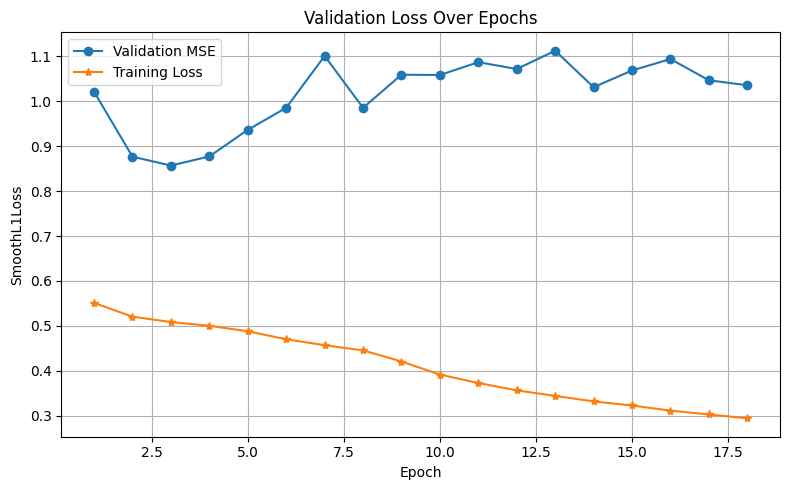

In [22]:
epochs = range(1, len(val_loss_history) + 1)
plt.figure(figsize=(8, 5))
plt.plot(epochs, val_loss_history, marker='o', label='Validation MSE')
plt.plot(epochs, train_loss_history, label="Training Loss", marker="*")
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Final Test Evaluation
model.eval()
test_loss = 0.0
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for test_x, test_idx, test_y in test_loader:
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_outputs = model(test_x, test_idx.to(device))  # shape: [batch_size, 2]

        loss_test = dual_mse_loss(test_outputs, test_y)
        test_loss += loss_test.item()

        y_true_test.extend(test_y.cpu().numpy())
        y_pred_test.extend(test_outputs.cpu().numpy())

# Convert to numpy
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)

# Metrics for Close_scaled (output[:, 0])
rmse_0 = mean_squared_error(y_true_test[:, 0], y_pred_test[:, 0]) ** 0.5
mae_0 = mean_absolute_error(y_true_test[:, 0], y_pred_test[:, 0])
r2_0 = r2_score(y_true_test[:, 0], y_pred_test[:, 0])
mape_0 = mean_absolute_percentage_error(y_true_test[:, 0], y_pred_test[:, 0])

# Metrics for Close_smoothed (output[:, 1])
rmse_1 = mean_squared_error(y_true_test[:, 1], y_pred_test[:, 1]) ** 0.5
mae_1 = mean_absolute_error(y_true_test[:, 1], y_pred_test[:, 1])
r2_1 = r2_score(y_true_test[:, 1], y_pred_test[:, 1])
mape_1 = mean_absolute_percentage_error(y_true_test[:, 1], y_pred_test[:, 1])

# Print results
print(f"[Close_scaled]   RMSE: {rmse_0:.5f} | MAE: {mae_0:.5f} | R²: {r2_0:.4f} | MAPE: {mape_0:.2f}%")
print(f"[Close_smoothed] RMSE: {rmse_1:.5f} | MAE: {mae_1:.5f} | R²: {r2_1:.4f} | MAPE: {mape_1:.2f}%")

[Close_scaled]   RMSE: 0.90453 | MAE: 0.68193 | R²: -0.1120 | MAPE: 238.24%
[Close_smoothed] RMSE: 0.20291 | MAE: 0.17356 | R²: 0.9277 | MAPE: 34.43%


## BackTesting

In [24]:
meta = meta_test.copy()

In [25]:
print(meta.head(10))

           Date Ticker     Close  Close_scaled  Close_smoothed
2161 2022-12-21    AGG  0.002753      0.823000       -0.210953
2162 2022-12-22    AGG -0.000305     -0.115555       -0.217008
2163 2022-12-23    AGG -0.003458     -1.083116       -0.248192
2164 2022-12-27    AGG -0.007247     -2.245670       -0.320729
2165 2022-12-28    AGG -0.001748     -0.558227       -0.364125
2166 2022-12-29    AGG  0.003708      1.115910       -0.351029
2167 2022-12-30    AGG -0.004720     -1.470318       -0.384704
2168 2023-01-03    AGG  0.005877      1.781440       -0.349955
2169 2023-01-04    AGG  0.005535      1.676584       -0.290373
2170 2023-01-05    AGG -0.000816     -0.272154       -0.273308


In [26]:
meta['prediction_scaled'] = y_pred_test[:,0]
meta['prediction_smoothed'] = y_pred_test[:,1]

,Date,Ticker,Close,Close_scaled,Close_smoothed,prediction_scaled,prediction_smoothed
2161,2022-12-21,AGG,0.002753,0.823000,-0.210953,0.473487,-0.347136
2162,2022-12-22,AGG,-0.000305,-0.115555,-0.217008,-0.595533,-0.188570
2163,2022-12-23,AGG,-0.003458,-1.083116,-0.248192,-0.282216,-0.094313
2164,2022-12-27,AGG,-0.007247,-2.245670,-0.320729,0.347887,-0.271232
2165,2022-12-28,AGG,-0.001748,-0.558227,-0.364125,1.408889,-0.450249
...,...,...,...,...,...,...,...
256685,2025-02-12,XLY,-0.000179,-0.059184,2.267787,-0.098319,1.947857
256686,2025-02-13,XLY,0.015017,1.106487,2.305487,-0.125736,1.922362
256687,2025-02-14,XLY,-0.000440,-0.079254,2.319252,-0.094116,1.906167
256688,2025-02-18,XLY,-0.002775,-0.258368,2.316476,-0.110900,1.920211


In [27]:
print(meta.columns)
print(meta.head(10))

Index(['Date', 'Ticker', 'Close', 'Close_scaled', 'Close_smoothed',
       'prediction_scaled', 'prediction_smoothed'],
      dtype='object')
           Date Ticker     Close  Close_scaled  Close_smoothed  \
2161 2022-12-21    AGG  0.002753      0.823000       -0.210953   
2162 2022-12-22    AGG -0.000305     -0.115555       -0.217008   
2163 2022-12-23    AGG -0.003458     -1.083116       -0.248192   
2164 2022-12-27    AGG -0.007247     -2.245670       -0.320729   
2165 2022-12-28    AGG -0.001748     -0.558227       -0.364125   
2166 2022-12-29    AGG  0.003708      1.115910       -0.351029   
2167 2022-12-30    AGG -0.004720     -1.470318       -0.384704   
2168 2023-01-03    AGG  0.005877      1.781440       -0.349955   
2169 2023-01-04    AGG  0.005535      1.676584       -0.290373   
2170 2023-01-05    AGG -0.000816     -0.272154       -0.273308   

      prediction_scaled  prediction_smoothed  
2161           0.473487            -0.347136  
2162          -0.595533            -0

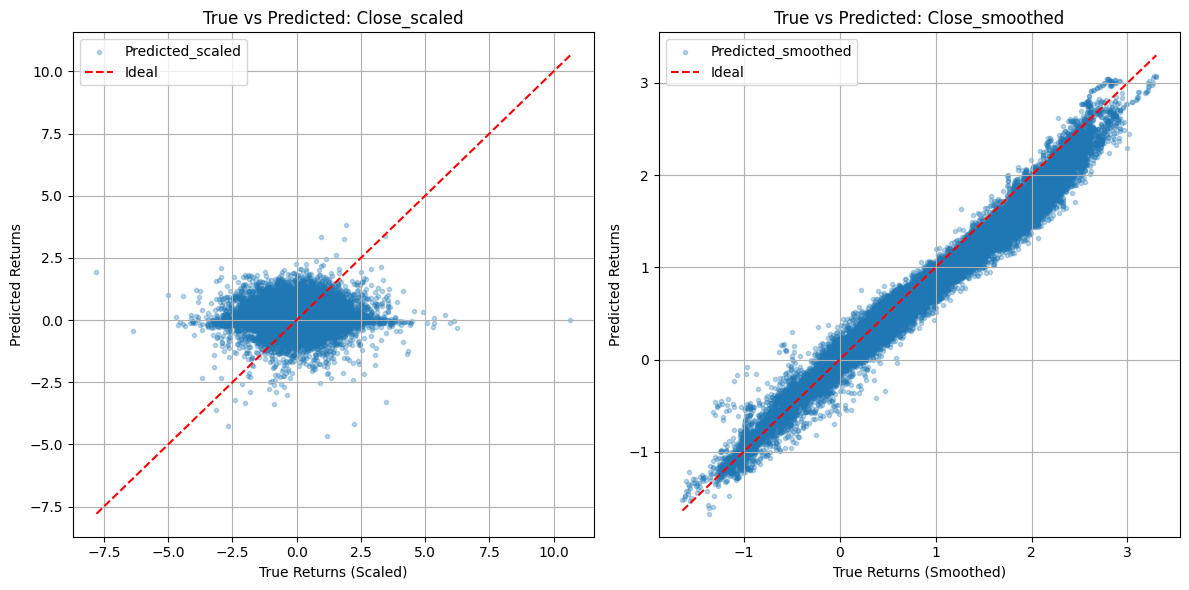

In [28]:
# Make sure y_true_test and y_pred_test are NumPy arrays
y_true_np = np.array(y_true_test)
y_pred_np = np.array(y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Close_scaled
axes[0].scatter(y_true_np[:, 0], y_pred_np[:, 0], alpha=0.3, label='Predicted_scaled', marker='.')
axes[0].plot([y_true_np[:, 0].min(), y_true_np[:, 0].max()],
             [y_true_np[:, 0].min(), y_true_np[:, 0].max()],
             color='red', linestyle='--', label='Ideal')
axes[0].set_xlabel('True Returns (Scaled)')
axes[0].set_ylabel('Predicted Returns')
axes[0].set_title('True vs Predicted: Close_scaled')
axes[0].legend()
axes[0].grid(True)

# Plot for Close_smoothed
axes[1].scatter(y_true_np[:, 1], y_pred_np[:, 1], alpha=0.3, label='Predicted_smoothed', marker='.')
axes[1].plot([y_true_np[:, 1].min(), y_true_np[:, 1].max()],
             [y_true_np[:, 1].min(), y_true_np[:, 1].max()],
             color='red', linestyle='--', label='Ideal')
axes[1].set_xlabel('True Returns (Smoothed)')
axes[1].set_ylabel('Predicted Returns')
axes[1].set_title('True vs Predicted: Close_smoothed')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [29]:
meta['rank'] = meta.groupby('Date')['prediction_scaled'].rank(method='first', ascending=False)

top_pct = 0.3
bottom_pct = 0.3

meta['n_assets'] = meta.groupby('Date')['prediction_scaled'].transform('count')
meta['signal'] = 0  # default to 0 (neutral)

meta.loc[meta['rank'] <= meta['n_assets'] * top_pct, 'signal'] = 1  # long
meta.loc[meta['rank'] > meta['n_assets'] * (1 - bottom_pct), 'signal'] = -1  # short

In [30]:
print(meta.tail(10))
Tickers = np.unique(meta['Ticker'])
print("\n", Tickers)
Tickers_count = len(np.array(Tickers))
print("/", Tickers_count)

             Date Ticker     Close  Close_scaled  Close_smoothed  \
256680 2025-02-05    XLY -0.011346     -0.915801        2.393969   
256681 2025-02-06    XLY  0.003971      0.259122        2.395135   
256682 2025-02-07    XLY -0.019558     -1.545767        2.336444   
256683 2025-02-10    XLY  0.003413      0.216367        2.323090   
256684 2025-02-11    XLY -0.011354     -0.916430        2.283963   
256685 2025-02-12    XLY -0.000179     -0.059184        2.267787   
256686 2025-02-13    XLY  0.015017      1.106487        2.305487   
256687 2025-02-14    XLY -0.000440     -0.079254        2.319252   
256688 2025-02-18    XLY -0.002775     -0.258368        2.316476   
256689 2025-02-19    XLY -0.000574     -0.089520        2.313657   

        prediction_scaled  prediction_smoothed  rank  n_assets  signal  
256680          -0.062206             2.090060  23.0        95       1  
256681          -0.054307             2.061862  20.0        95       1  
256682          -0.049569       

In [31]:
print(meta.groupby('Date').head())

            Date Ticker     Close  Close_scaled  Close_smoothed  \
2161  2022-12-21    AGG  0.002753      0.823000       -0.210953   
2162  2022-12-22    AGG -0.000305     -0.115555       -0.217008   
2163  2022-12-23    AGG -0.003458     -1.083116       -0.248192   
2164  2022-12-27    AGG -0.007247     -2.245670       -0.320729   
2165  2022-12-28    AGG -0.001748     -0.558227       -0.364125   
...          ...    ...       ...           ...             ...   
13505 2025-02-12    DVY -0.005399     -0.532048        2.114477   
13506 2025-02-13    DVY  0.009369      0.816135        2.142245   
13507 2025-02-14    DVY -0.000221     -0.059357        2.152596   
13508 2025-02-18    DVY  0.010169      0.889093        2.191523   
13509 2025-02-19    DVY  0.004523      0.373680        2.222722   

       prediction_scaled  prediction_smoothed  rank  n_assets  signal  
2161            0.473487            -0.347136  58.0        95       0  
2162           -0.595533            -0.188570  88.0

In [32]:
# Compute daily return of long-short strategy
strategy_returns = []

for date, group in meta.groupby('Date'):
    longs = group[group['signal'] == 1]
    shorts = group[group['signal'] == -1]

    # These are average returns since 'Close' already holds return values
    long_avg_return = longs['Close'].mean() if len(longs) > 0 else 0
    short_avg_return = shorts['Close'].mean() if len(shorts) > 0 else 0

    # Net daily return from $1 long per long ETF and $1 short per short ETF
    daily_return = long_avg_return - short_avg_return
    strategy_returns.append({'Date': date, 'strategy_return': daily_return})

strategy_df = pd.DataFrame(strategy_returns)
strategy_df['Date'] = pd.to_datetime(strategy_df['Date'])
strategy_df.set_index('Date', inplace=True)

# Cumulative return (simple sum of daily returns)
strategy_df['cum_return'] = strategy_df['strategy_return'].cumsum()

In [33]:
daily_mean = strategy_df['strategy_return'].mean()
daily_std = strategy_df['strategy_return'].std()
sharpe_ratio = (daily_mean / daily_std) * np.sqrt(252) if daily_std != 0 else np.nan
total_return = strategy_df['cum_return'].iloc[-1]
annualized_return = np.exp(daily_mean * 252) - 1
annualized_volatility = strategy_df['strategy_return'].std() * np.sqrt(252)

# Maximum drawdown
strategy_df['cum_max'] = strategy_df['cum_return'].cummax()
strategy_df['drawdown'] = strategy_df['cum_return'] - strategy_df['cum_max']
max_drawdown = strategy_df['drawdown'].min()

print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Annualized Volatility: {annualized_volatility:.4f}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Total Percentage Return: {total_return:.4f}")


Max Drawdown: -4.76%
Sharpe Ratio: 1.0908
Annualized Volatility: 0.0691
Annualized Return: 7.83%
Total Percentage Return: 0.1618


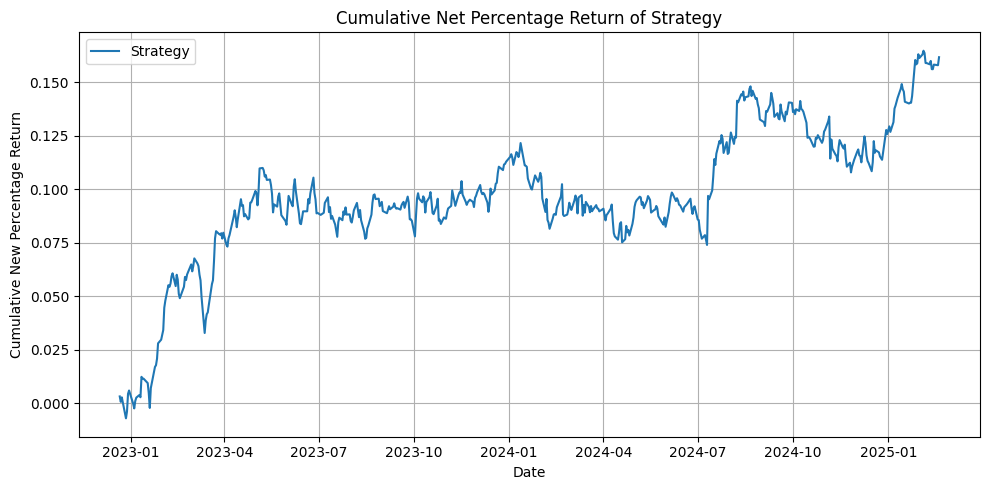

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(strategy_df.index, strategy_df['cum_return'], label='Strategy')
plt.title('Cumulative Net Percentage Return of Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative New Percentage Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
print(meta['signal'].value_counts())

signal
 0    20558
-1    15689
 1    15148
Name: count, dtype: int64


In [38]:
var_true = np.var(y_true_test[:,0])
var_pred = np.var(y_pred_test[:,0])

print(f"Variance of y_true_scaled: {var_true:.6f}")
print(f"Variance of y_pred_scaled: {var_pred:.6f}")

var_true_smoothed = np.var(y_true_test[:,1])
var_pred_smoothed = np.var(y_pred_test[:,1])

print(f"Variance of y_true_smoothed: {var_true_smoothed:.6f}")
print(f"Variance of y_pred_smoothed: {var_pred_smoothed:.6f}")

Variance of y_true_scaled: 0.735777
Variance of y_pred_scaled: 0.102442
Variance of y_true_smoothed: 0.569060
Variance of y_pred_smoothed: 0.459072


In [42]:
# ---------- naive baseline (lag‑1) ---------------------------------------
meta_test_sorted = meta_test.reset_index(drop=True)          # align order

y_train = np.array(y_train)
y_baseline = np.mean(y_train[:, 0])  # mean of Close_scaled
baseline_preds = [y_baseline] * len(y_true_test)

r2_baseline = r2_score(y_true_test[:, 0], baseline_preds)
naive_rmse = mean_squared_error(y_true_test[:, 0], baseline_preds) ** 0.5
naive_mae = mean_absolute_error(y_true_test[:, 0], baseline_preds)
naive_mape = mean_absolute_percentage_error(y_true_test[:, 0], baseline_preds)

print("Naive R² :", r2_baseline)
print("Naive RMSE  :", naive_rmse)
print("Naive MAE   :", naive_mae)
print("Naive MAPE  :", naive_mape)


Naive R² : -0.00028383731842041016
Naive RMSE  : 0.8578961218704804
Naive MAE   : 0.6514995098114014
Naive MAPE  : 102.73112


Save my checkpoints


In [43]:
checkpoint = {
  'epoch': epoch+1,
  'model_state_dict': model.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
  'val_losses': val_loss_history,
  'meta': meta.to_dict(orient='records'),
  'return': strategy_df.to_dict(orient='records'),
  }

torch.save(checkpoint, 'checkpoint_separateTickers.pth')

In [44]:
from google.colab import files
files.download('checkpoint_separateTickers.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>